# Server Failure Detection with Anomaly Detection Algorithm

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

### Load Data

In [21]:
data = loadmat('serverdata.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

Text(0, 0.5, 'Throughput (mb/s)')

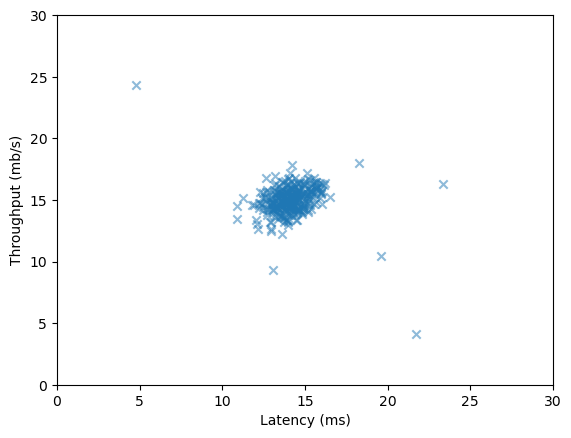

In [22]:
plt.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.5)
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

### Gaussian Distribution

In [23]:
def estimateGaussian(X):
    m, n = X.shape
    mu = (1/m) * np.sum(X, axis=0)
    sigma2 = (1/m) * np.sum((X - mu)**2, axis=0)
    return mu, sigma2

### Multivariate Gaussian

In [24]:
def multivariateGaussian(X, mu, sigma2):
    k = len(mu)
    sigma2 = np.diag(sigma2)
    X = X - mu.T
    p = 1/ ((2*np.pi)**(k/2) * (np.linalg.det(sigma2)**0.5)) * np.exp( -0.5 * np.sum(X @ np.linalg.pinv(sigma2) * X, axis=1))
    return p

In [25]:
mu, sigma2 = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma2)

/var/folders/yc/7t2g4m1j7_b7zd6sjmybdkq40000gn/T/ipykernel_90514/1274310390.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  contour_level = np.power(10, np.array([np.arange(-20, 0, 3, dtype=np.float)]))[0]


Text(0, 0.5, 'Throughput (mb/s)')

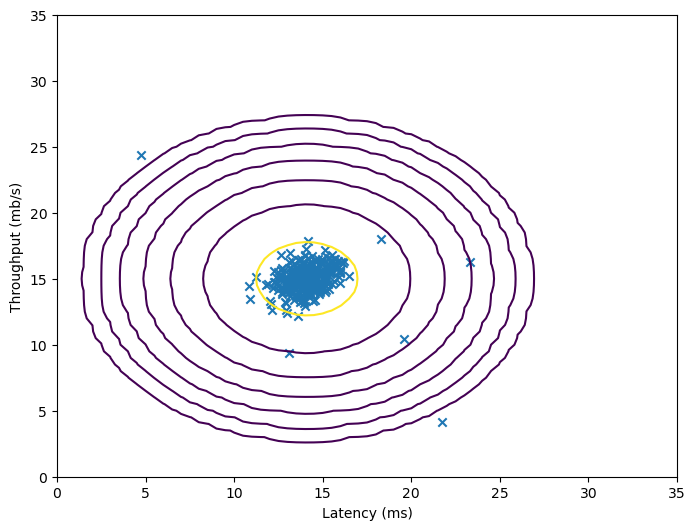

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1],marker="x")
X1, X2 = np.meshgrid(np.linspace(0, 35, num=71), np.linspace(0, 35, num=71))
p2 = multivariateGaussian(np.column_stack((X1.flatten().reshape(-1, 1), X2.flatten().reshape(-1, 1))), mu, sigma2)
contour_level = np.power(10, np.array([np.arange(-20, 0, 3, dtype=np.float)]))[0]
plt.contour(X1, X2, p2.reshape(X1.shape), contour_level)
plt.xlim(0,35)
plt.ylim(0,35)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

### Selecting Threshold

In [27]:
def selectThreshold(yval, pval):
    bestEpsilon = 0
    bestF1 = 0
    step = (max(pval) - min(pval))/1000
    epi_range = np.arange(min(pval), max(pval), step)
    for epsilon in epi_range:
        
        predictions = (pval < epsilon).reshape(-1, 1)
        
        true_positive = np.sum(predictions[yval==1]==1)
        false_positive = np.sum(predictions[yval==0]==1)
        false_negative = np.sum(predictions[yval==1]==0)
        
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        
        F1 = (2*precision*recall)/(precision + recall)
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon,  bestF1

In [28]:
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)
print("Best epsilon found using cross-validation:",epsilon)
print("Best F1 on Cross Validation Set:",F1)

Best epsilon found using cross-validation: 8.990852779269495e-05
Best F1 on Cross Validation Set: 0.8750000000000001


/var/folders/yc/7t2g4m1j7_b7zd6sjmybdkq40000gn/T/ipykernel_90514/2955906054.py:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)


/var/folders/yc/7t2g4m1j7_b7zd6sjmybdkq40000gn/T/ipykernel_90514/3214870262.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  contour_level = 10**np.array([np.arange(-20,0,3,dtype=np.float)])[0]


Text(0, 0.5, 'Throughput (mb/s)')

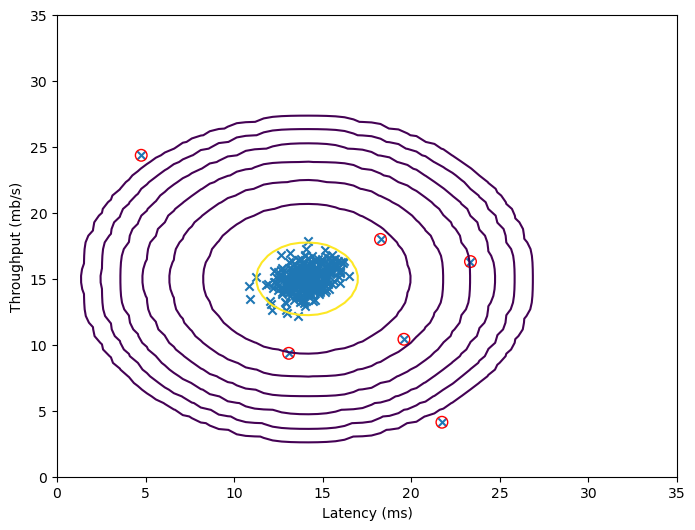

In [29]:
plt.figure(figsize=(8,6))

plt.scatter(X[:,0],X[:,1],marker="x")

X1,X2 = np.meshgrid(np.linspace(0,35,num=70),np.linspace(0,35,num=70))
p2 = multivariateGaussian(np.hstack((X1.flatten()[:,np.newaxis],X2.flatten()[:,np.newaxis])), mu, sigma2)
contour_level = 10**np.array([np.arange(-20,0,3,dtype=np.float)])[0]
plt.contour(X1,X2,p2[:,np.newaxis].reshape(X1.shape),contour_level)

outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker ="o",facecolor="none",edgecolor="r",s=70)

plt.xlim(0,35)
plt.ylim(0,35)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

### Testing on High-dimensional Dataset

In [30]:
mat2 = loadmat("serverdata2.mat")
X2 = mat2["X"]
Xval2 = mat2["Xval"]
yval2 = mat2["yval"]

In [31]:
mu2, sigma2_2 = estimateGaussian(X2)

In [32]:
p3 = multivariateGaussian(X2, mu2, sigma2_2)

pval2 = multivariateGaussian(Xval2, mu2, sigma2_2)

epsilon2, F1_2 = selectThreshold(yval2, pval2)
print("Best epsilon found using cross-validation:",epsilon2)
print("Best F1 on Cross Validation Set:",F1_2)
print("# Outliers found:",np.sum(p3<epsilon2))

Best epsilon found using cross-validation: 1.3772288907613575e-18
Best F1 on Cross Validation Set: 0.6153846153846154
# Outliers found: 117


/var/folders/yc/7t2g4m1j7_b7zd6sjmybdkq40000gn/T/ipykernel_90514/2955906054.py:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)
